**Autor:** Dávid Dráb  <br> *[Prírodovedecká fakulta](https://www.upjs.sk/en/faculty-of-science/?prefferedLang=EN), Univerzita Pavla Jozefa Šafárika, Košice 2023* <br> email: [david.drab163@gmail.com](mailto:david.drab163@gmail.com).
***
**<font size=6.5 color=darkblue> Analýza hlavných komponentov pre funkconálne dáta II </font>**  

--- 
<a id=obsah></a>

**<font size=5.5 color=darkblue> Obsah </font>** <br>
1. [Úmrtnosť mužov na Slovensku v rokoch 1950 až 2019](#prvy)


2. [Porovnanie PCA a FPCA](#porovnanie)


3. [Výnosy Istanbulskej burzy cenných papierov](#druhy)


4. [Zdroje](#References)

--- 
<a id=prvy></a>
**<font size=5 color=darkblue> 1. Úmrtnosť mužov na Slovensku v rokoch 1950 až 2019 </font>** <br>

**<font size=4 color=darkblue> 1.1 Popis skúmaných dát </font>** <br>

Našimi skúmanými dátami sú logaritmické hodnoty miery úmrtnosti mužov na Slovensku vo veku 0 až 97 medzi rokmi 1950 až 2019. Tieto dáta pochádzajú z online databázy [*Human Mortality Database*](https://www.mortality.org/Country/Country?cntr=SVK), ktoré sme si ešte upravili v excelovskom súbore. 

In [1]:
# instalacia a inicializacia potrebnych balikov a kniznic
options(warnings=-1)
suppressMessages(library("fda", quietly = TRUE, verbose = FALSE))
suppressMessages(library("readr", quietly = TRUE, verbose = FALSE))
suppressMessages(library("refund", quietly = TRUE, verbose = FALSE))
suppressMessages(library("readxl", quietly = TRUE, verbose = FALSE))
suppressMessages(library("fields", quietly = TRUE, verbose = FALSE))

Warning message:
"package 'fda' was built under R version 4.1.3"
Warning message:
"package 'refund' was built under R version 4.1.3"
Warning message:
"package 'fields' was built under R version 4.1.3"


Na nasledujúcom obrázku pozorujeme, že majú charakter tzv. rastových kriviek. 

In [2]:
umrtnost_SVK_muzi <- read_delim("C:/Users/david/jupyter_ntb/umrtnost_SVK_muzi.csv", 
    delim = ";", escape_double = FALSE, trim_ws = TRUE)

data<-as.matrix(umrtnost_SVK_muzi)
data2<-log(data)
vek<-1:98
n<-ncol(data2)

Rows: 98 Columns: 70
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ";"
dbl (70): 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


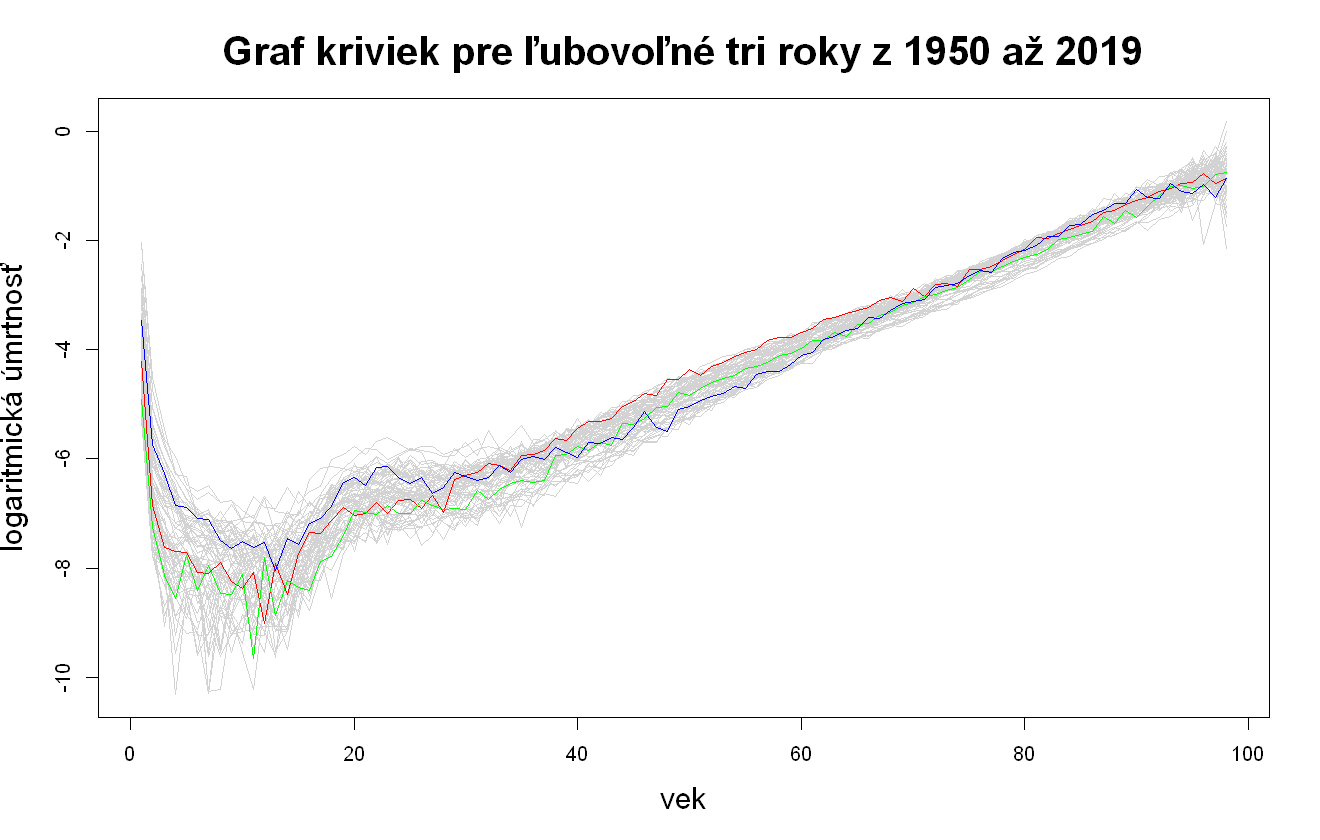

In [3]:
options(repr.plot.width=11, repr.plot.height=7)
matplot(vek,data2, type='l', lty=1, col="lightgray", main="Graf kriviek pre ľubovoľné tri roky z 1950 až 2019", 
        cex.main=2, cex.lab=1.5, ylab="logaritmická úmrtnosť")
vybrane_krivky<- sample(1:n, size = 3, replace = FALSE)
matlines(data2[,vybrane_krivky], type='l', lty=1, lwd=1, col = rainbow(3))

Na grafe môžeme vidieť celkom výraznú odchýlku do 20. roka života a menšiu medzi 20. a 40. rokom života, čo môže popisovať celkový pokrok v spoločnosti, resp. v poskytovanej zdravotnej starostlivosti pre deti a dorast. To isté by mohlo platiť aj pre síce menšiu odchýlku vo vysokom veku nad 90 rokov.

**<font size=4 color=darkblue> 1.2 Implementácia FPCA a interpretácia výsledkov </font>** <br>

Teraz si vyhladíme všetky naše krivky pomocou funkcie gam a následne si vykreslíme pôvodné a vyladené vybrané krivky.

Warning message:
"package 'mgcv' was built under R version 4.1.3"
Loading required package: nlme

This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



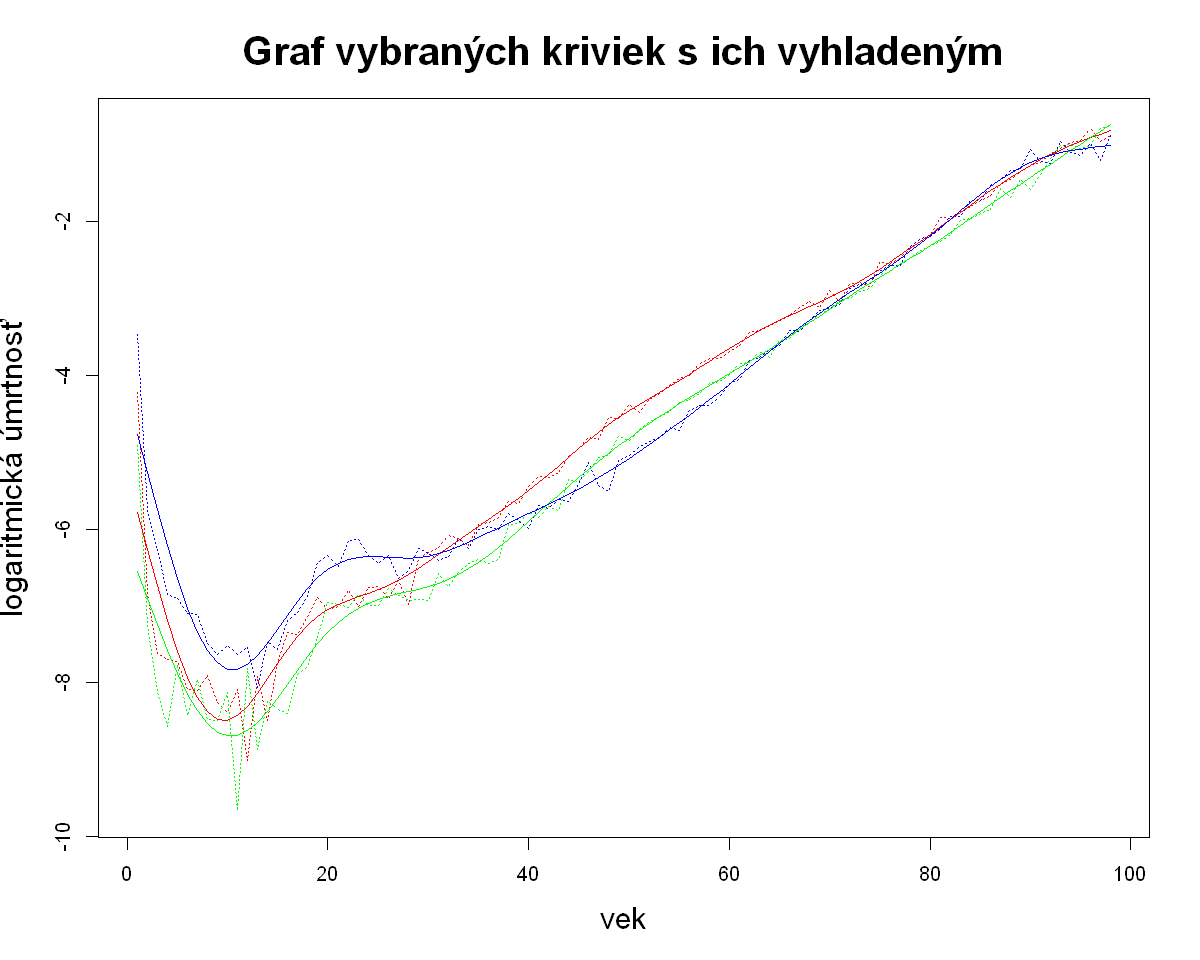

In [4]:
options(warnings=-1)
library(mgcv)
vyhladene_krivky<- array(0, dim(data2))
for(j in 1:n){
  fit <- gam(data2[,j] ~ s(vek,k=15, bs = 'tp'), method = "REML")
  vyhladene_krivky[,j] <- fit$fitted
}

options(repr.plot.width=10, repr.plot.height=8)
matplot(vek,data2[,vybrane_krivky], 
        type='l', lty=3, lwd=1, col = rainbow(3), main="Graf vybraných kriviek s ich vyhladeným", cex.main=2, cex.lab=1.55, 
        ylab="logaritmická úmrtnosť")
matlines(vek,vyhladene_krivky[,vybrane_krivky], 
         type='l', lty=1, lwd=1, col = rainbow(3))

Pre FPCA je dôležitá funckia premeru vyhladených kriviek.

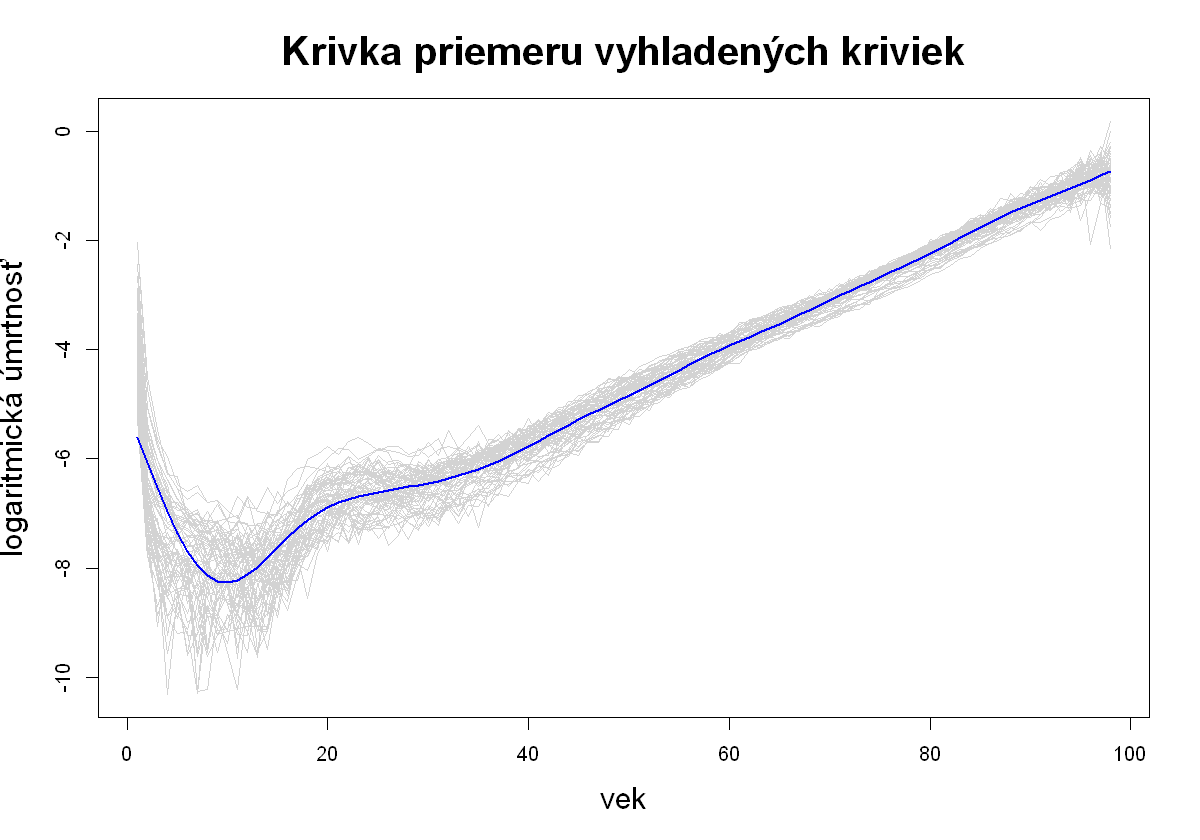

In [5]:
mean.hat <- rowMeans(vyhladene_krivky)
options(repr.plot.width=10, repr.plot.height=7)
matplot(vek, data2, type='l', lty=1, col="lightgray", main="Krivka priemeru vyhladených kriviek", cex.main=2, cex.lab=1.55
       , ylab="logaritmická úmrtnosť")
lines(mean.hat, col='blue', lwd=2)

Ďalšou podstatnou funkciou je funkcia kovariancie vyhladených kriviek.

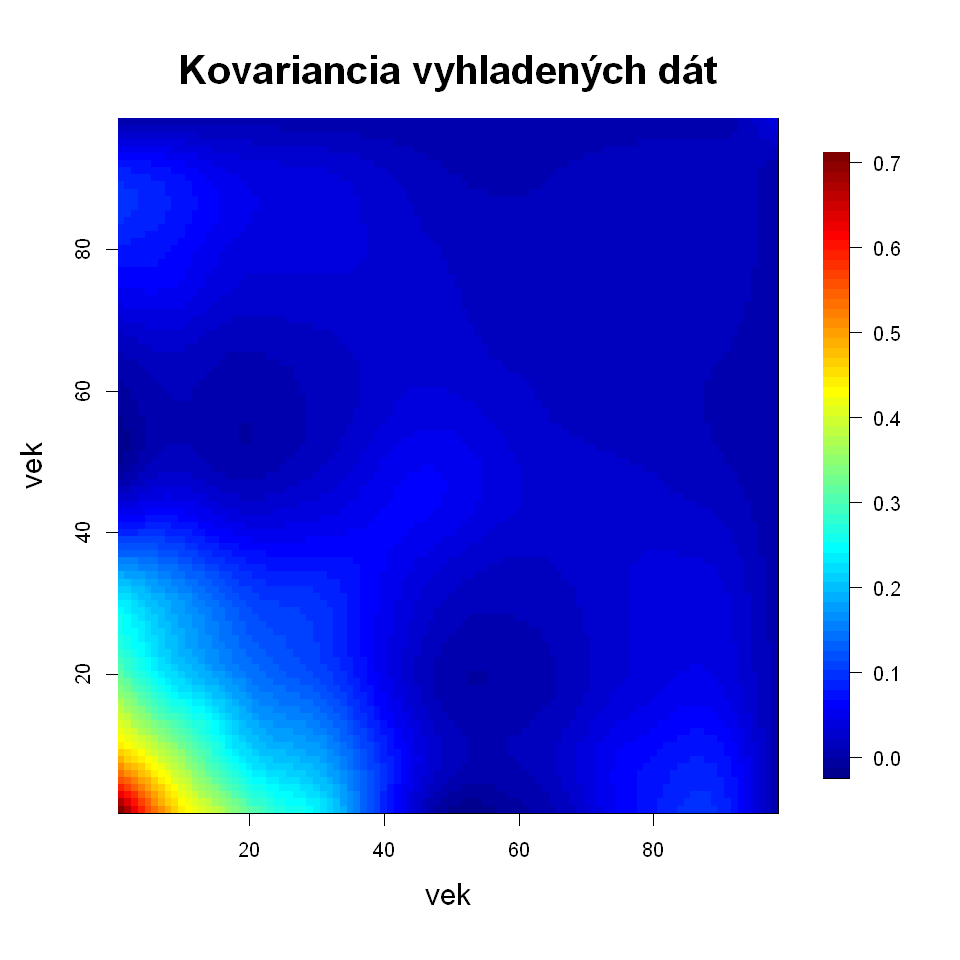

In [6]:
vyhladena_kov <- cov(t(vyhladene_krivky))
options(repr.plot.width=8, repr.plot.height=8)
image.plot(vek, vek, vyhladena_kov, main='Kovariancia vyhladených dát', cex.main=2, cex.lab=1.5)

Môžeme vidieť, že do približne 20. roku života sú krivky mierne závislé. Po 40. roku života už nevykazujú skoro žiadnu závislosť.

Teraz prevedieme ("ručne") výpočet pre získanie vlastných funkcií, či určenia počtu komponentov.

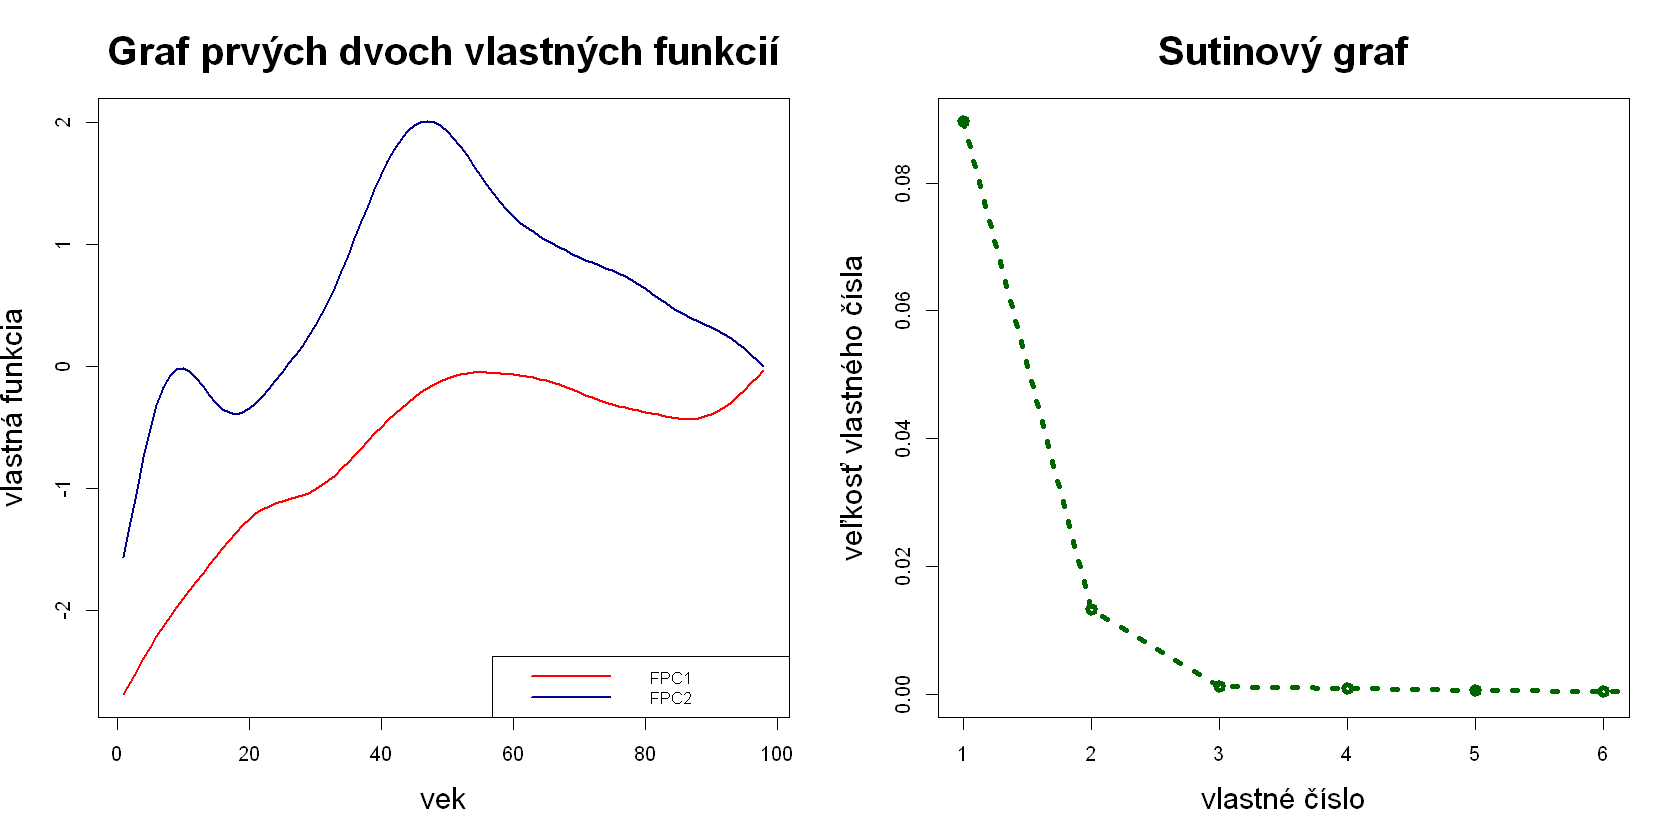

In [7]:
svd.result0 <- eigen(vyhladena_kov, symmetric = TRUE)

evectors <- svd.result0$vectors[,svd.result0$values > 0]
evalues <- svd.result0$values[svd.result0$values > 0]

par(mfrow=c(1,2))

efns0 <- evectors*sqrt(98)
evals0 <- evalues/98
pveFPCA <- cumsum(evals0)/sum(evals0)
npcFPCA <- sum(pveFPCA < 0.95) + 1
efns <- efns0[,1:npcFPCA]
evals <- evals0[1:npcFPCA]

options(repr.plot.width=14, repr.plot.height=7)
matplot(vek, efns[,1:npcFPCA], col=c("red", "darkblue"), 
        type='l', lty=1, lwd=2,
        ylab="vlastná funkcia", xlab="vek",
        main="Graf prvých dvoch vlastných funkcií",cex.main=2, cex.lab=1.5)
legend("bottomright", lwd=2, lty=1, col=c("red", "darkblue"), 
      legend = paste0("FPC", 1:npcFPCA),cex=0.8)
plot(1:length(evals0),evals0,type='o',lty=3, col='darkgreen',lwd=4 ,main="Sutinový graf", cex.main=2,cex.lab=1.5, 
     xlab="vlastné číslo", ylab="veľkosť vlastného čísla", xlim=c(1,6))

Podľa grafu sme určili, že (až) 97% rozptylu vysvetlia 2 komponenty. Vysvetlenie a určenie vlastných funkcií je na tejto metóde najťažšie. Čierna prvá vlastná funkcia môže popisovať vývoj odchýlky od piremeru vyhladených kriviek. Zhruba do veku 40 rokov je odchýlka vyššia od priemeru, ako po veku 40 rokov. Červená druhá vlastná funkcia môže popisovať zmeny v úmrtnosti medzi približne 40. a 60. rokom života. Pre lepšie pochopenie si teraz ukážeme tieto skutočnosti podrobnejšie v nasledujúcich grafoch.


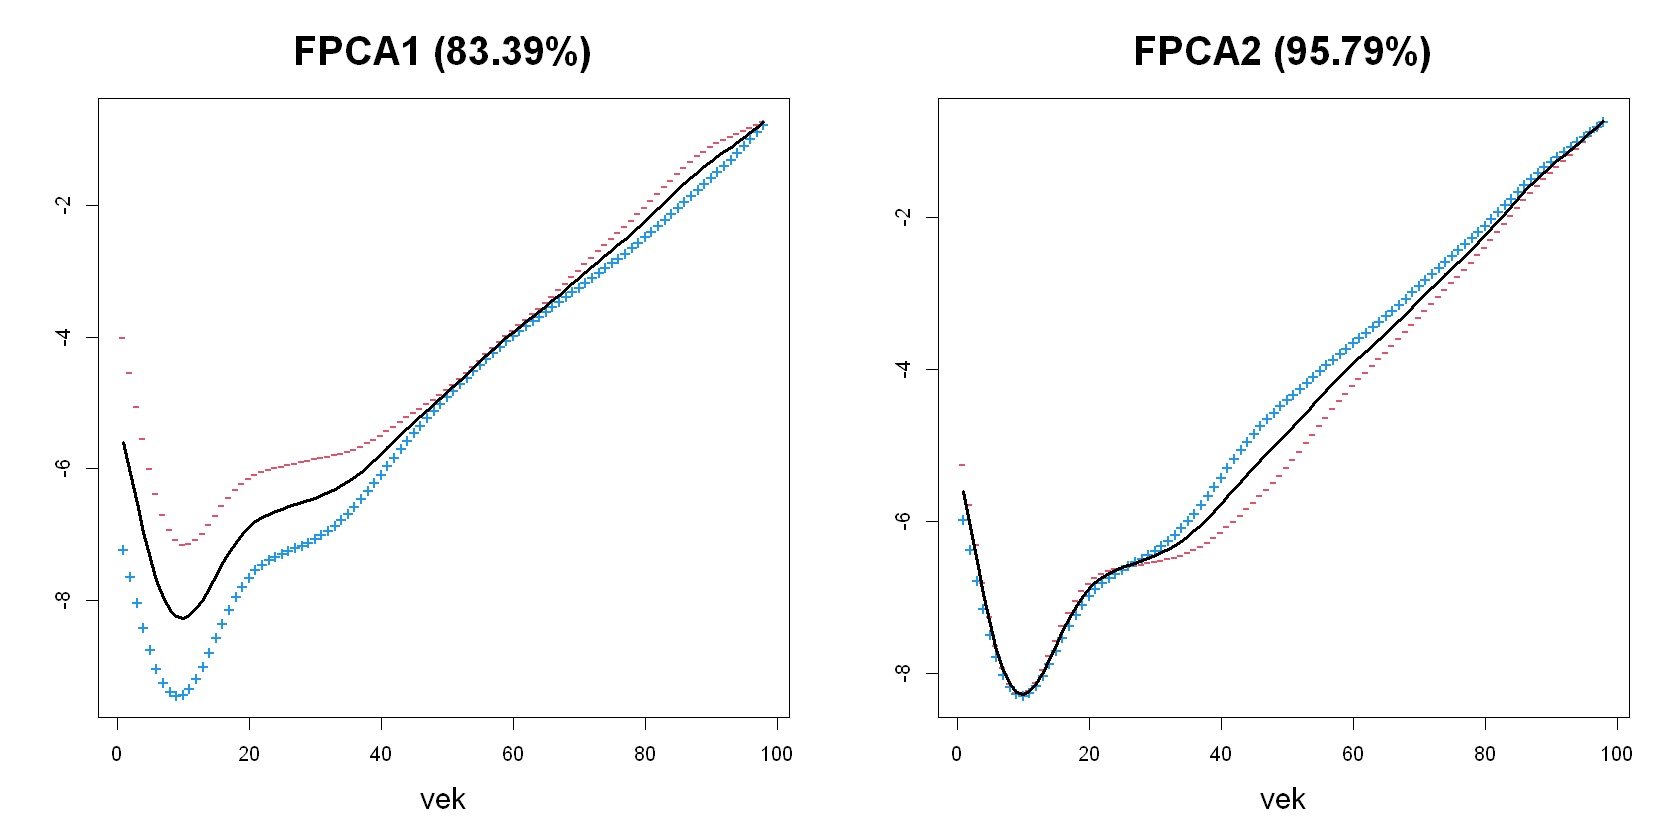

In [8]:
par(mfrow=c(1,2))
options(repr.plot.width=14, repr.plot.height=7)
for (i in 1:2){
k.pc <- i
mu.hat <- mean.hat
effect <- efns0[,k.pc] * 2* sqrt(evals0[k.pc])
pve.face <- (cumsum(evals0)/sum(evals0))
matplot(vek, cbind(mu.hat - effect, mu.hat + effect),
        pch = c("-", "+"), ylab="", xlab="vek", col=c(2,4),lwd=3,
        main=paste0("FPCA", k.pc," (", round(pve.face[k.pc]*100,2) ,"%)"), cex.main=2, cex.lab=1.5)
lines(vek, mu.hat, lty=1, lwd=3)
    }

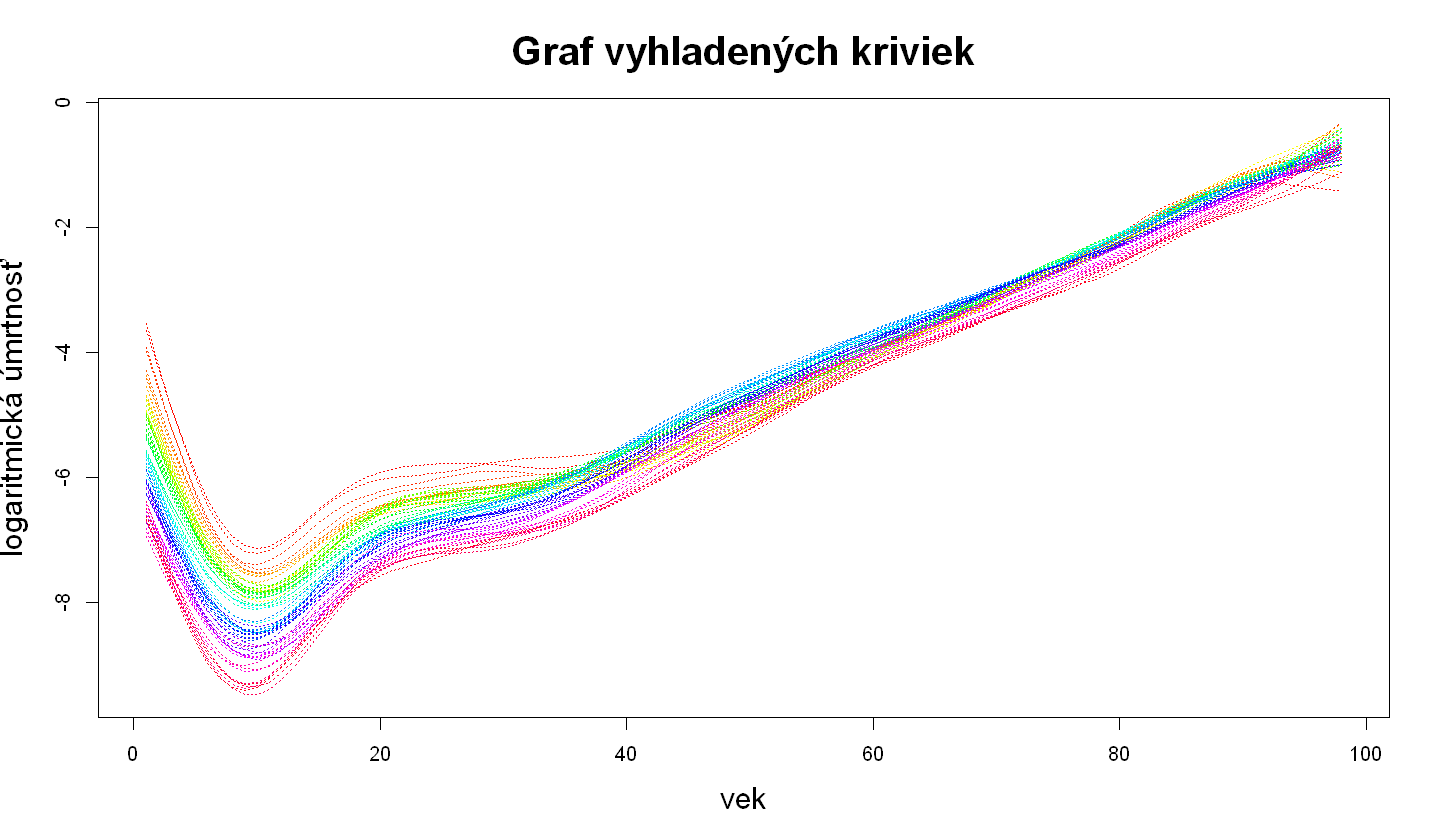

In [9]:
options(repr.plot.width=12, repr.plot.height=7)
matplot(vek,vyhladene_krivky, 
        type='l', lty=3, lwd=1, col = rainbow(n), main="Graf vyhladených kriviek", cex.main=2, cex.lab=1.55,
        ylab="logaritmická úmrtnosť")

V grafe možeme vidieť, že zhruba od 30. veku života dochádza k zmenám medzi jednotlivými krivkami, pričom je vidno aj zmeny vo vyššom veku. Časom sa rozptyl zmenšuje a tiež, že ako konkrétne dochádza k zmene v krivkách.

V programe R už existujú aj naprogramované metódy, ktoré ulahčujú výpočet. Nasledujúci kód nám vypočíta a vykreslí aj vlastné funkcie, ktoré sú totožné. 

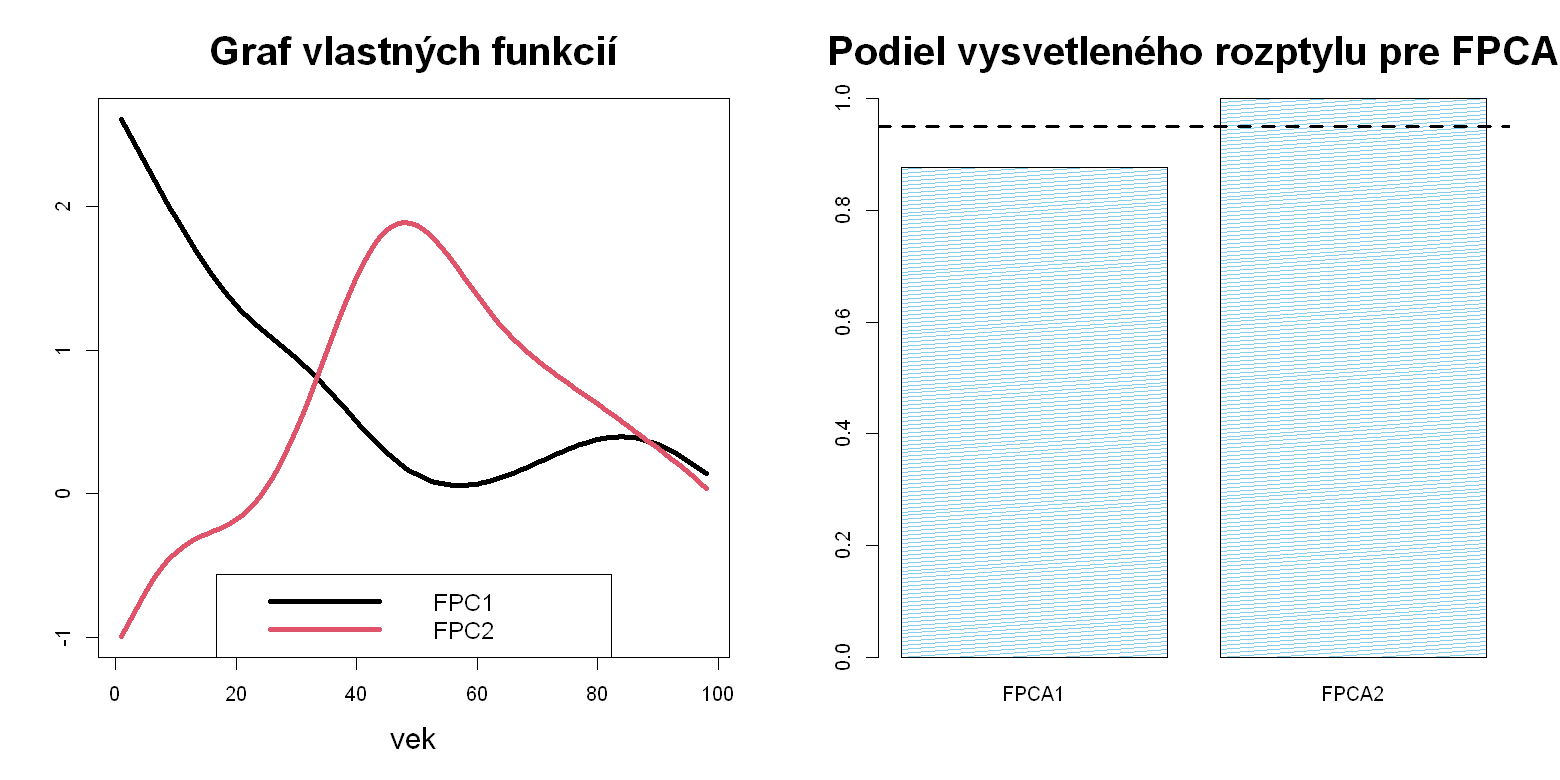

In [10]:
res.face <- fpca.face(Y = t(data2), argvals = vek, pve = 0.97)
efn.face <- res.face$efunctions*sqrt(98)
eval.face <- res.face$evalues/98
pve.face <- (cumsum(eval.face)/sum(eval.face))

options(repr.plot.width=13, repr.plot.height=6.5)
par(mfrow=c(1,2))
matplot(vek, efn.face[,1:res.face$npc], col=1:res.face$npc, 
        type='l', lty=1, lwd=4,
        xlab="vek",ylab="",
        main="Graf vlastných funkcií", cex.main=2, cex.lab=1.5)
legend("bottom", lwd=4, lty=1, col=1:res.face$npc, 
      legend = paste0("FPC", 1:res.face$npc),cex=1.2)
barplot(pve.face, ylim=c(0,1), col="skyblue", main="Podiel vysvetleného rozptylu pre FPCA", cex.main=2, 
        names.arg = c("FPCA1","FPCA2"),density=c(30,30) , angle=c(11,11) )
abline(0.95,0, lwd=3, lty=2)

Účinok každého komponentu by sme mohli vyzualizovať a to aj s pomocou 

$$\mu(t) \pm 2\sqrt{\lambda_k}\beta_k(t),$$

kde $\mu(t)$ je funkcia priemeru, $\lambda_k$ je $k$-te vlastné číslo a $\beta_k(t)$ je jej zodpovedajúci vlastný vektor (vzhľadom na diskreditáciu funkcie pracujeme reálne s vektorom, nie s funkciou). Na záver si vykeslíme aj vybrané vyhladené krivky s pôvodnými dátami vykeslenými ako body.

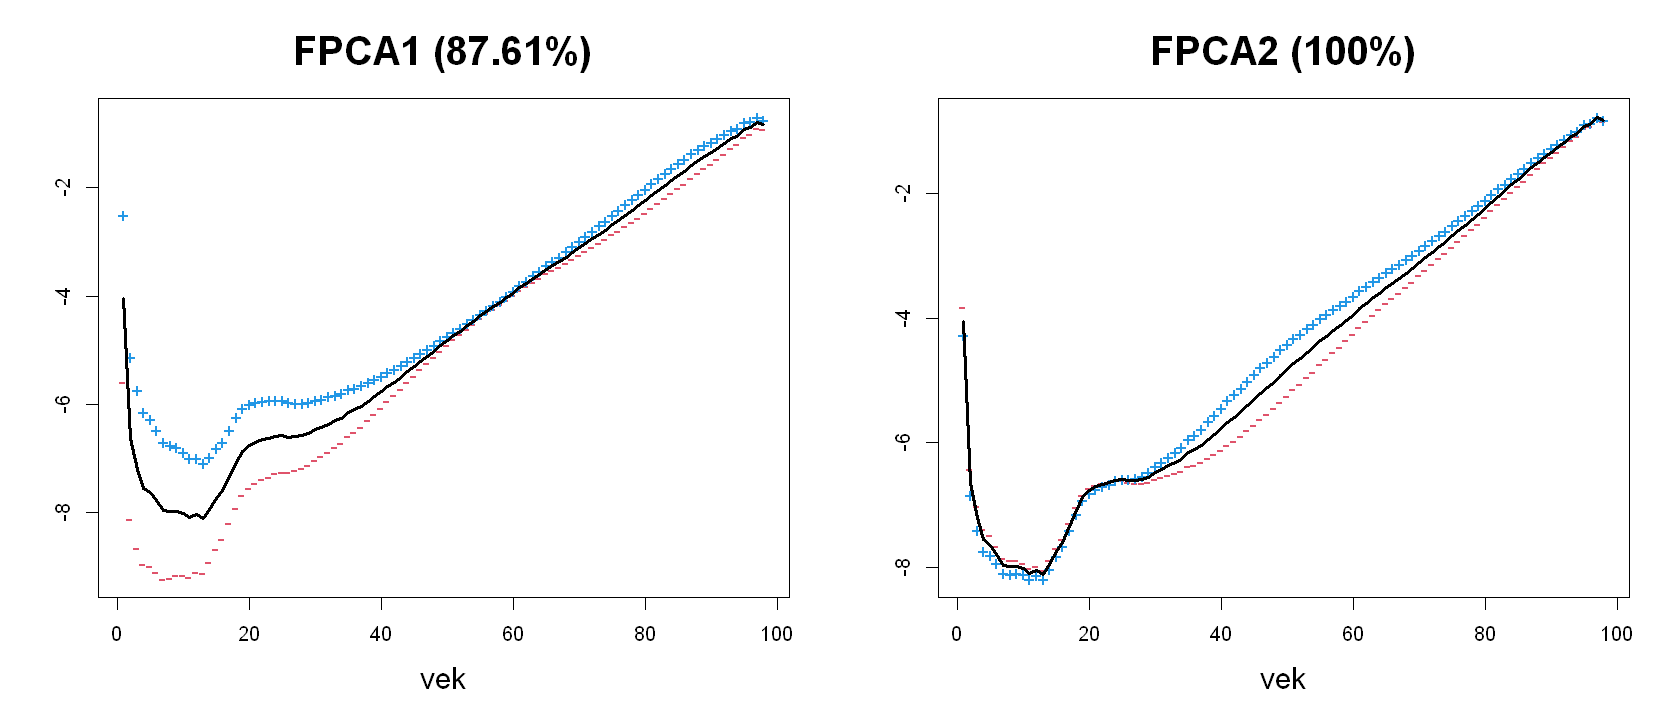

In [11]:
par(mfrow=c(1,2))
options(repr.plot.width=14, repr.plot.height=6)
for (i in 1:res.face$npc){
k.pc <- i
mu.hat <- res.face$mu
effect <- efn.face[,k.pc] * 2* sqrt(eval.face[k.pc])

matplot(vek, cbind(mu.hat - effect, mu.hat + effect),
        pch = c("-", "+"), ylab="", xlab="vek", col=c(2,4),lwd=3,
        main=paste0("FPCA", k.pc," (", round(pve.face[k.pc]*100,2) ,"%)"), cex.main=2, cex.lab=1.5)
lines(vek, mu.hat, lty=1, lwd=3)
    }

* Prvý komponent dáva do kostrastu roky, ktoré sa líšia počas prvých 40 rokov a veľmi slabo líšia potom nad vekom 80 rokov.
* Druhý komponent dáva do kontrastu roky, ktoré sa líšia medzi zhruba 30. a 70. rokom života.

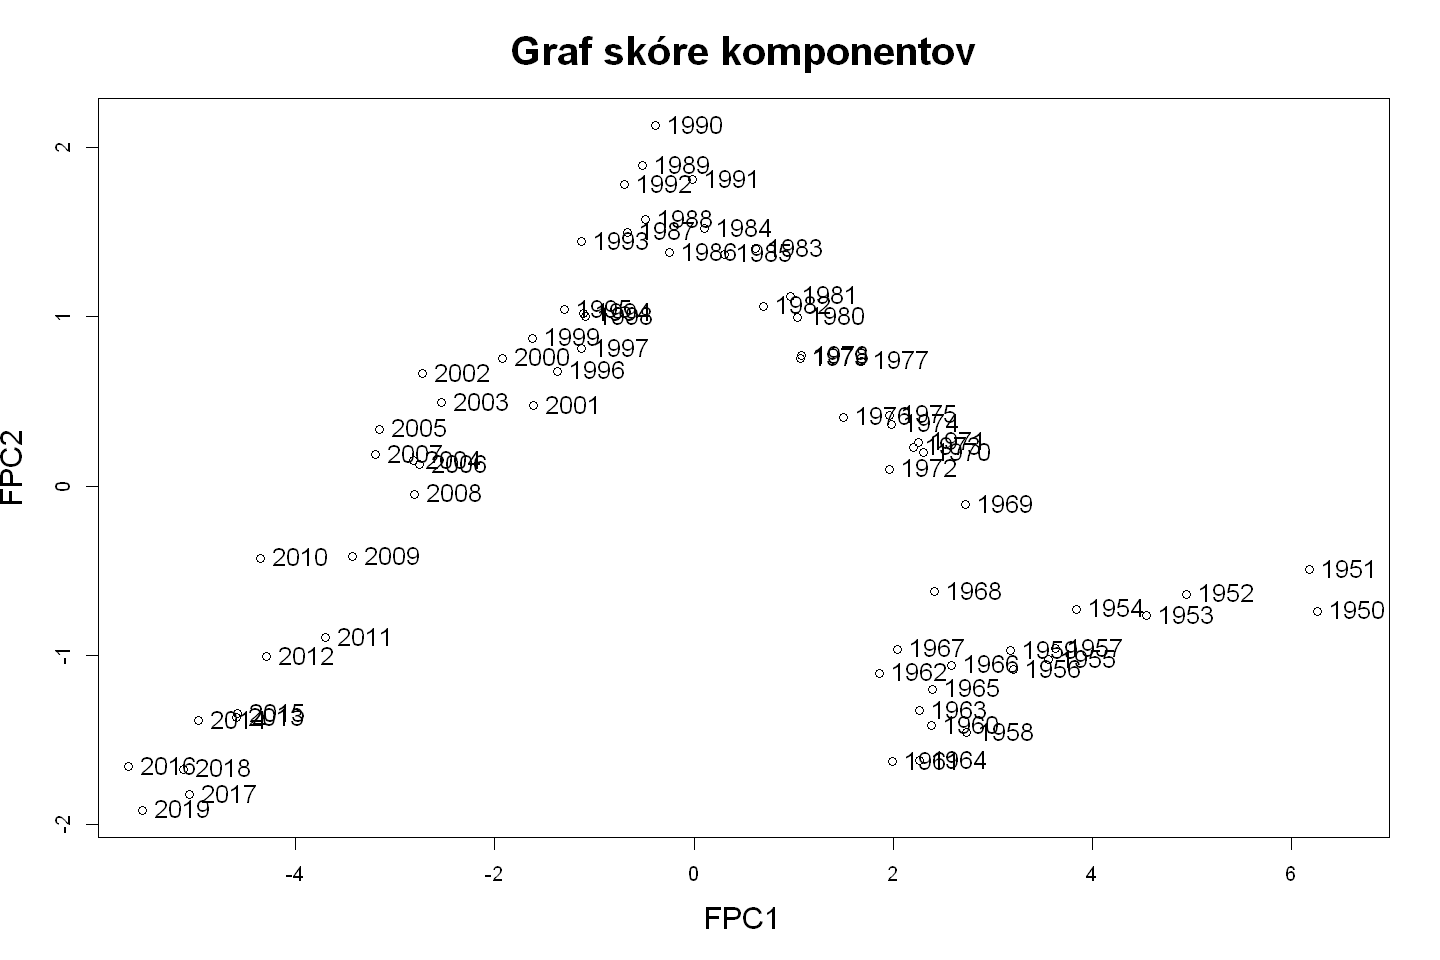

In [12]:
options(repr.plot.width=12, repr.plot.height=8)
plot(res.face$scores, xlab="FPC1", ylab="FPC2", main="Graf skóre komponentov", cex.main=2, cex.lab=1.5, xlim=c(-5.5,6.5))
text(res.face$scores[,1],res.face$scores[,2],rownames(res.face$scores),pos=4, cex=1.25)

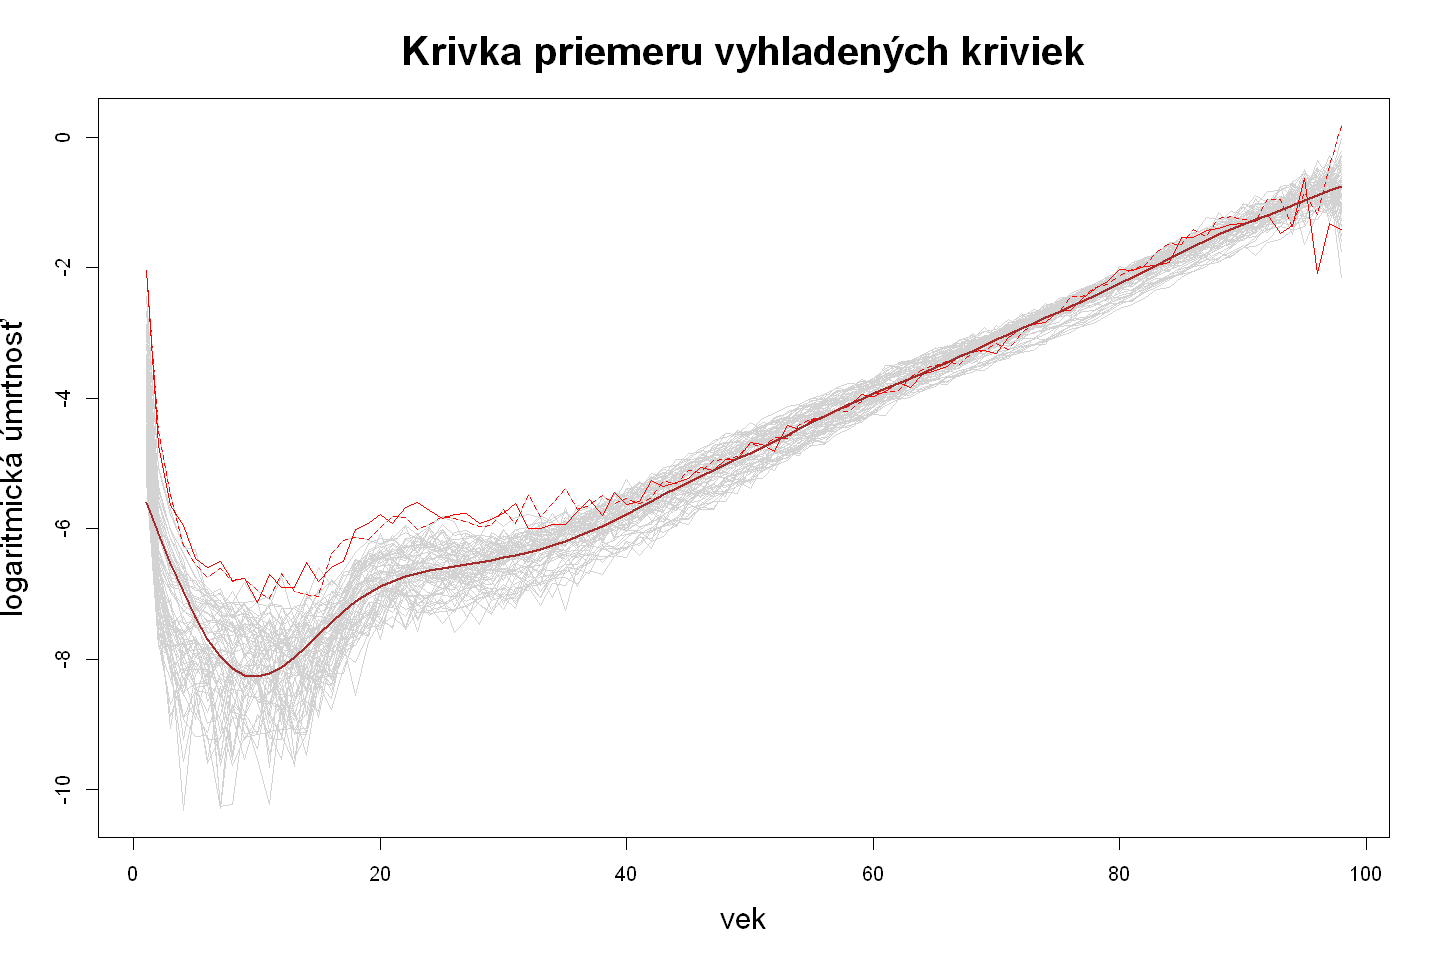

In [13]:
options(repr.plot.width=12, repr.plot.height=8)
matplot(vek, data2, type='l', lty=1, col="lightgray", main="Krivka priemeru vyhladených kriviek", cex.main=2, cex.lab=1.55
       , ylab="logaritmická úmrtnosť")
matlines(data2[,1:2], col="red")
lines(mean.hat, col='brown', lwd=2)

* Môžeme vidieť, že vysoké skóre prvého komponentu majú roky 1951 a 1950 a najnižšie skóre roky 2016 a 2019, čo vyplýva z toho, že v 50. rokoch 20. storočia bola vyššia úmrtnosť a časom sa znižovala (vo všeobecnosti). 
* Vysoké skóre druhého komponentu majú roky začiatku 90. rokov a najnižšie skóre roky 2019 a 2017, ale aj 1964 a 1961. Teda druhý komponent dáva do kontrastu krivky medzi vekom 30 až 70 rokov. 

Tieto výsledky sú rovnaké, aké sme dostali z grafov pre účinok každého komponentu. 

---

<a id=porovnanie></a>
**<font size=5 color=darkblue> 2. Porovnanie PCA a FPCA </font>** <br>

V tejto časti si porovnáme výsledky klasickej PCA a FPCA. Kedže dáta máme úplne, môžeme ich použiť aj v klasicej PCA. V nasledujúcich grafoch máme porovnanie počtu komponentov a ich vysvetľujúci rozptyl pôvodných dát s vykreslenou hranicou 85% resp. 95% vysvetleného rozptylu.

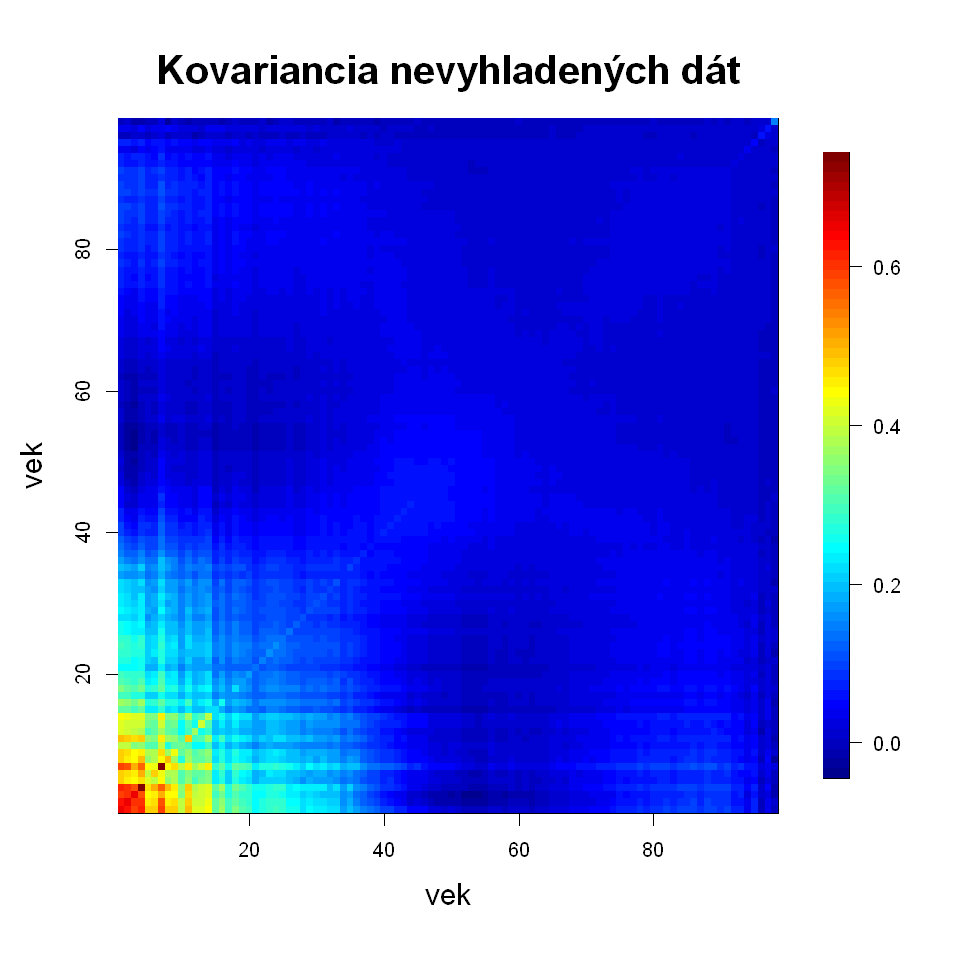

In [14]:
vyhladena_kov <- cov(t(data2))
options(repr.plot.width=8, repr.plot.height=8)
image.plot(vek, vek, vyhladena_kov, main='Kovariancia nevyhladených dát', cex.main=2, cex.lab=1.5)

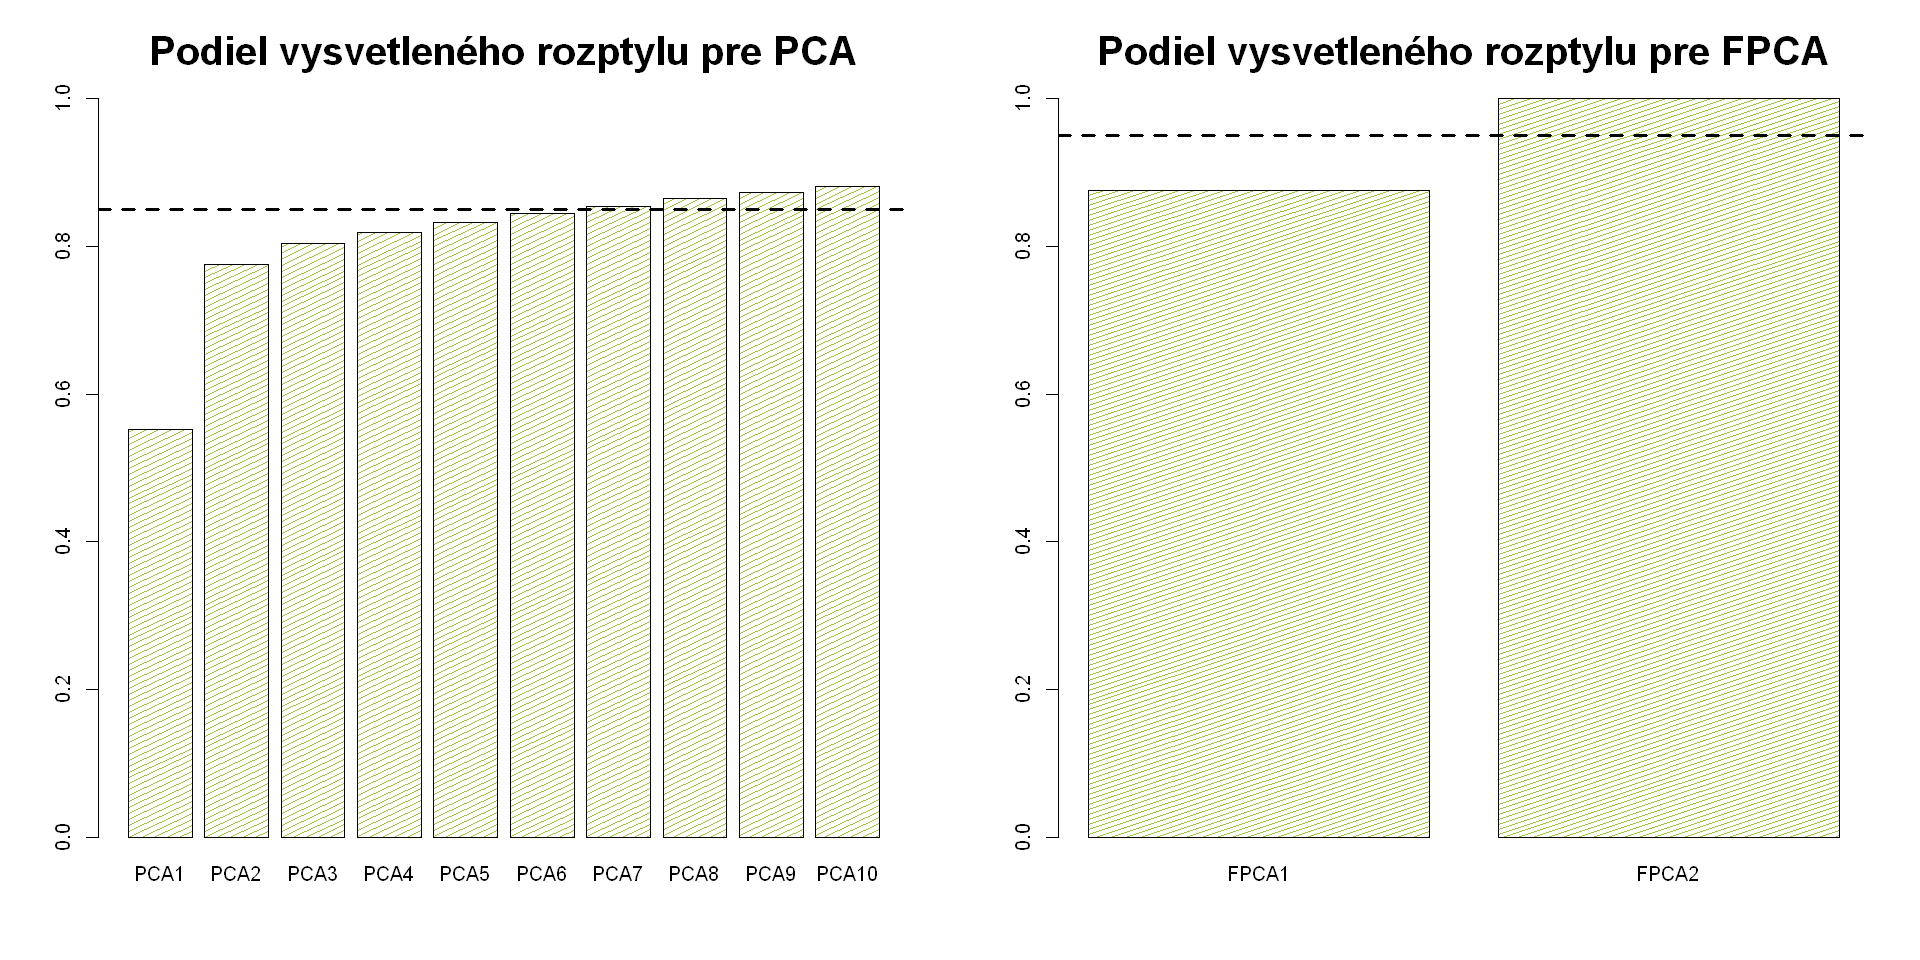

In [15]:
pca<-prcomp(t(data2),scale = TRUE, center=TRUE)
var_explained <- pca$sdev^2/sum(pca$sdev^2)
pvePCA <- cumsum(var_explained)/sum(var_explained)
npcPCA <- sum(pvePCA < 0.80) + 1

options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(1,2))
barplot(pvePCA[1:10], ylim=c(0,1), col="yellowgreen", main="Podiel vysvetleného rozptylu pre PCA", cex.main=2, 
        names.arg = c("PCA1","PCA2","PCA3","PCA4","PCA5","PCA6","PCA7","PCA8","PCA9","PCA10"),density=c(40,40) , angle=c(50,50))
abline(0.85,0, lwd=3, lty=2)

barplot(pve.face, ylim=c(0,1), col="yellowgreen", main="Podiel vysvetleného rozptylu pre FPCA", cex.main=2, 
        names.arg = c("FPCA1","FPCA2"),density=c(40,40) , angle=c(40,40))
abline(0.95,0, lwd=3, lty=2)

Pri klasickej PCA až 7 komponentov vysvetlí 85% rozptylu, pričom pre FPCA prvý komponent vysvetlí cez 80% rozptylu. Pre dané dáta funkcionálny prístup zredukoval pôvodné premenné ešte viac, ako klasický prístup. 

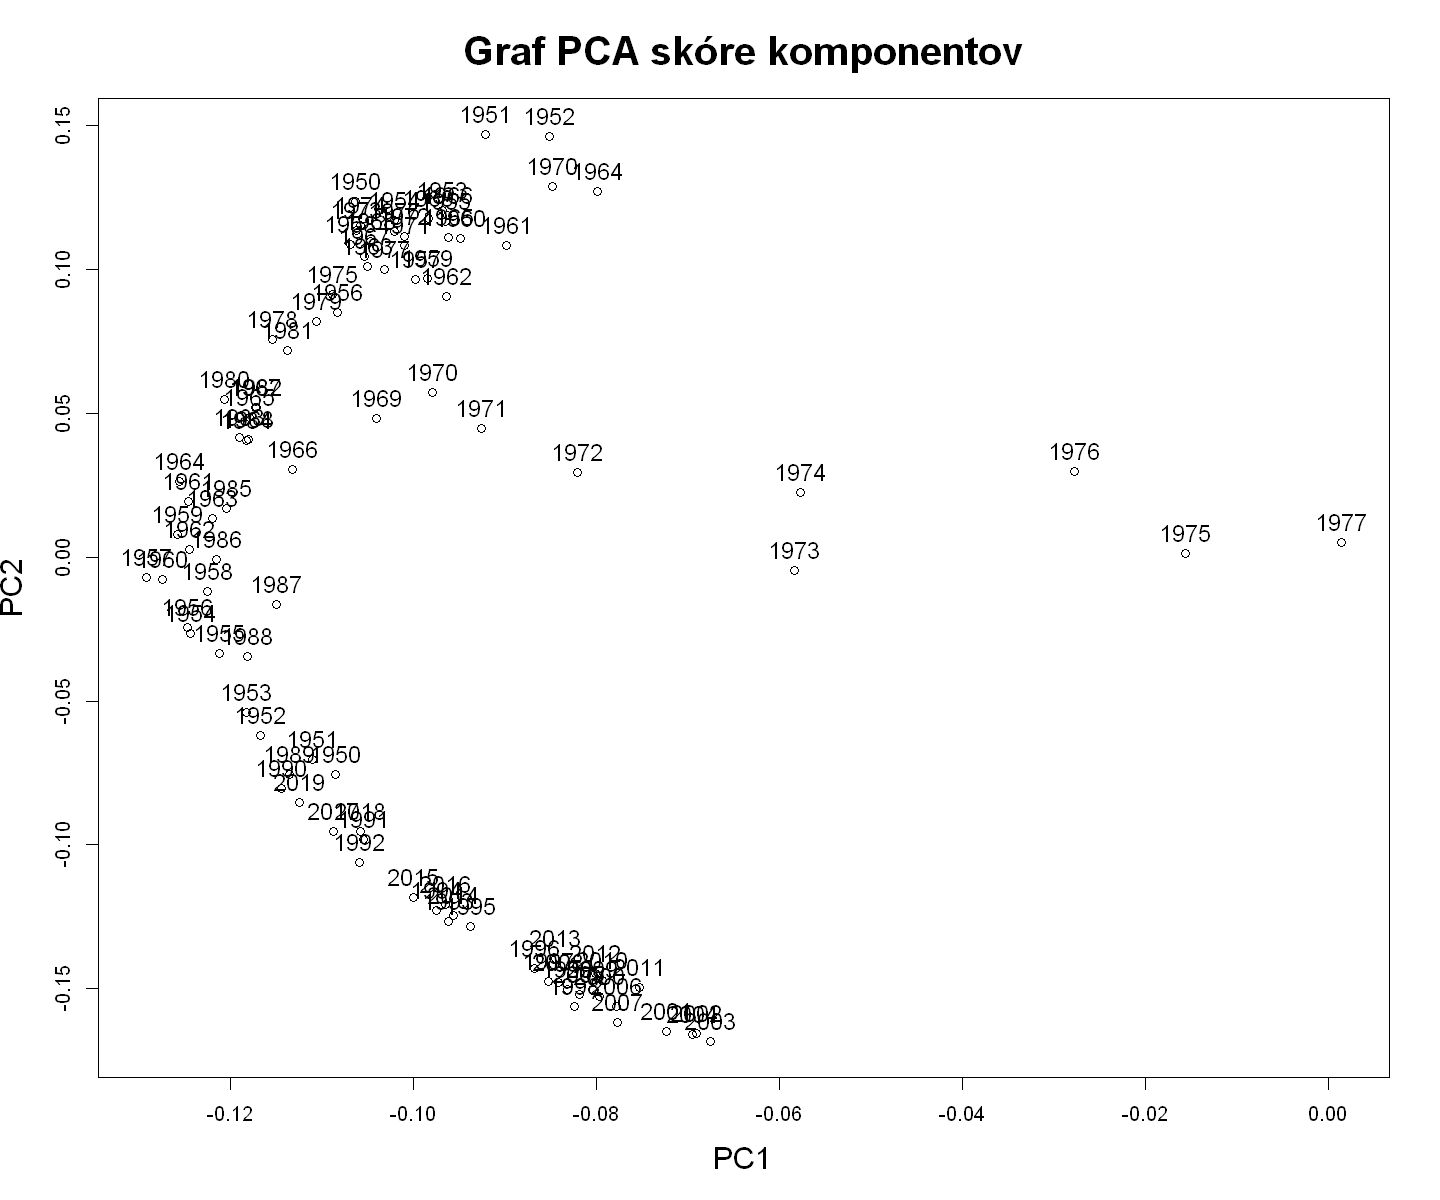

In [16]:
options(repr.plot.width=12, repr.plot.height=10)
plot(pca$rotation[,1:2],xlab="PC1", ylab="PC2", main="Graf PCA skóre komponentov", cex.main=2, cex.lab=1.5)
text(pca$rotation[,1],pca$rotation[,2],1950:2019,pos=3, cex=1.15)

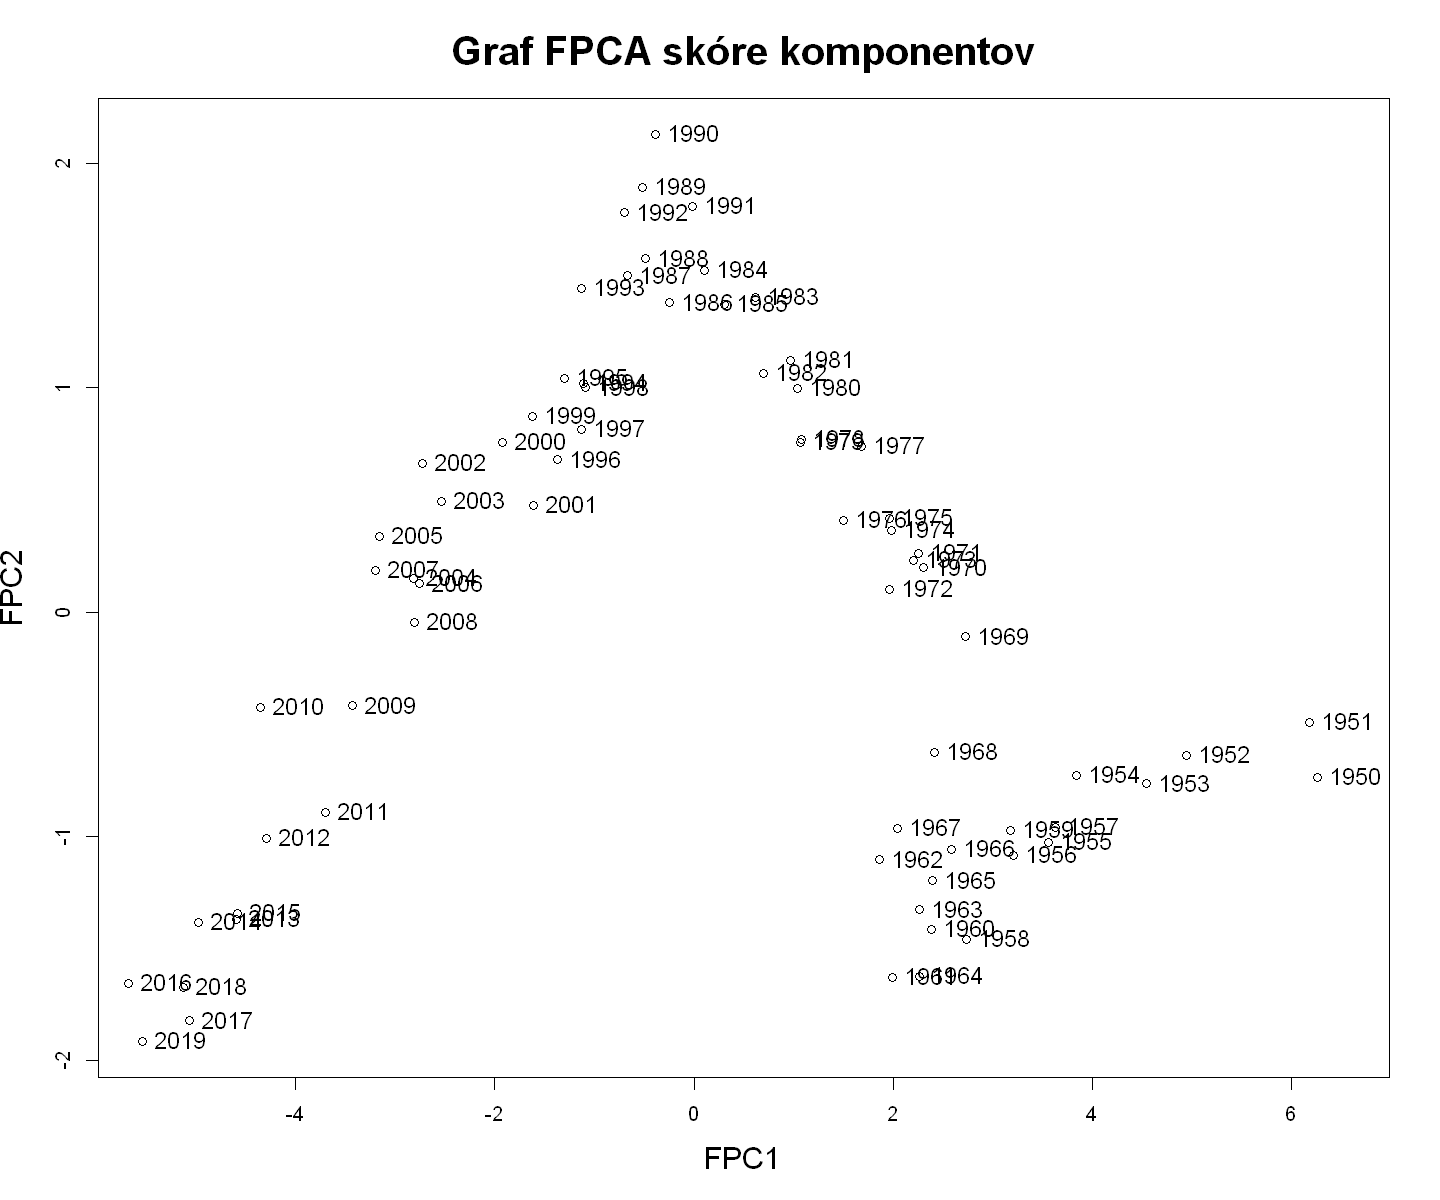

In [17]:
plot(res.face$scores, xlab="FPC1", ylab="FPC2", main="Graf FPCA skóre komponentov", cex.main=2, cex.lab=1.5, xlim=c(-5.5,6.5))
text(res.face$scores[,1],res.face$scores[,2],rownames(res.face$scores),pos=4, cex=1.15)

V prípade porovnania skóre komponentov vidíme zásadné rozdiely medzi klasickým a funkcionálnym prístupom. Nedá sa vo všeobecnosti povedať, kedy je lepší prvý, alebo druhý prístup. Pre dané dáta sa ukazuje, že FPCA zredukovala ešte viac dimenziu pôvodných dát. Avšak mohli by sme prísť o zaujimavé informácie z interpretácií komponentov klasicej PCA.

--- 
<a id=druhy></a>
**<font size=5 color=darkblue> 3. Výnosy Istanbulskej burzy cenných papierov </font>** <br>

**<font size=4 color=darkblue> 3.1 Popis skúmaných dát </font>** <br>

Dátový súbor zahŕňa výnosy Istanbulskej burzy cenných papierov so siedmimi ďalšími medzinárodnými indexmi:
* SP - Standard and Poor's 500 , 
* DAX - Nemecký index ,
* FTSE - Britský index  , 
* NIKKEI - Japonský index, 
* BOVESPA - Brazílsky index, 
* MSCE_EU - index krjín (bývalej politickej) západnej Európy, 
* MSCI_EM - index pre krajiny rýchlo sa rozvíjajúcich ázijských krajín,

 meraných od 5. júna 2009 do 22. februára 2011.
 
Tieto dáta sú dostupné v [*UCI Machine Learning Repository*](http://archive.ics.uci.edu/ml/datasets/ISTANBUL+STOCK+EXCHANGE), ako excelovský súbor.

In [18]:
data <- read_excel("C:/Users/david/jupyter_ntb/data_burza.xlsx")
typeof(data[,-1])
cas<-1:536

New names:
* `ISE` -> `ISE...2`
* `ISE` -> `ISE...3`


[1] "list"

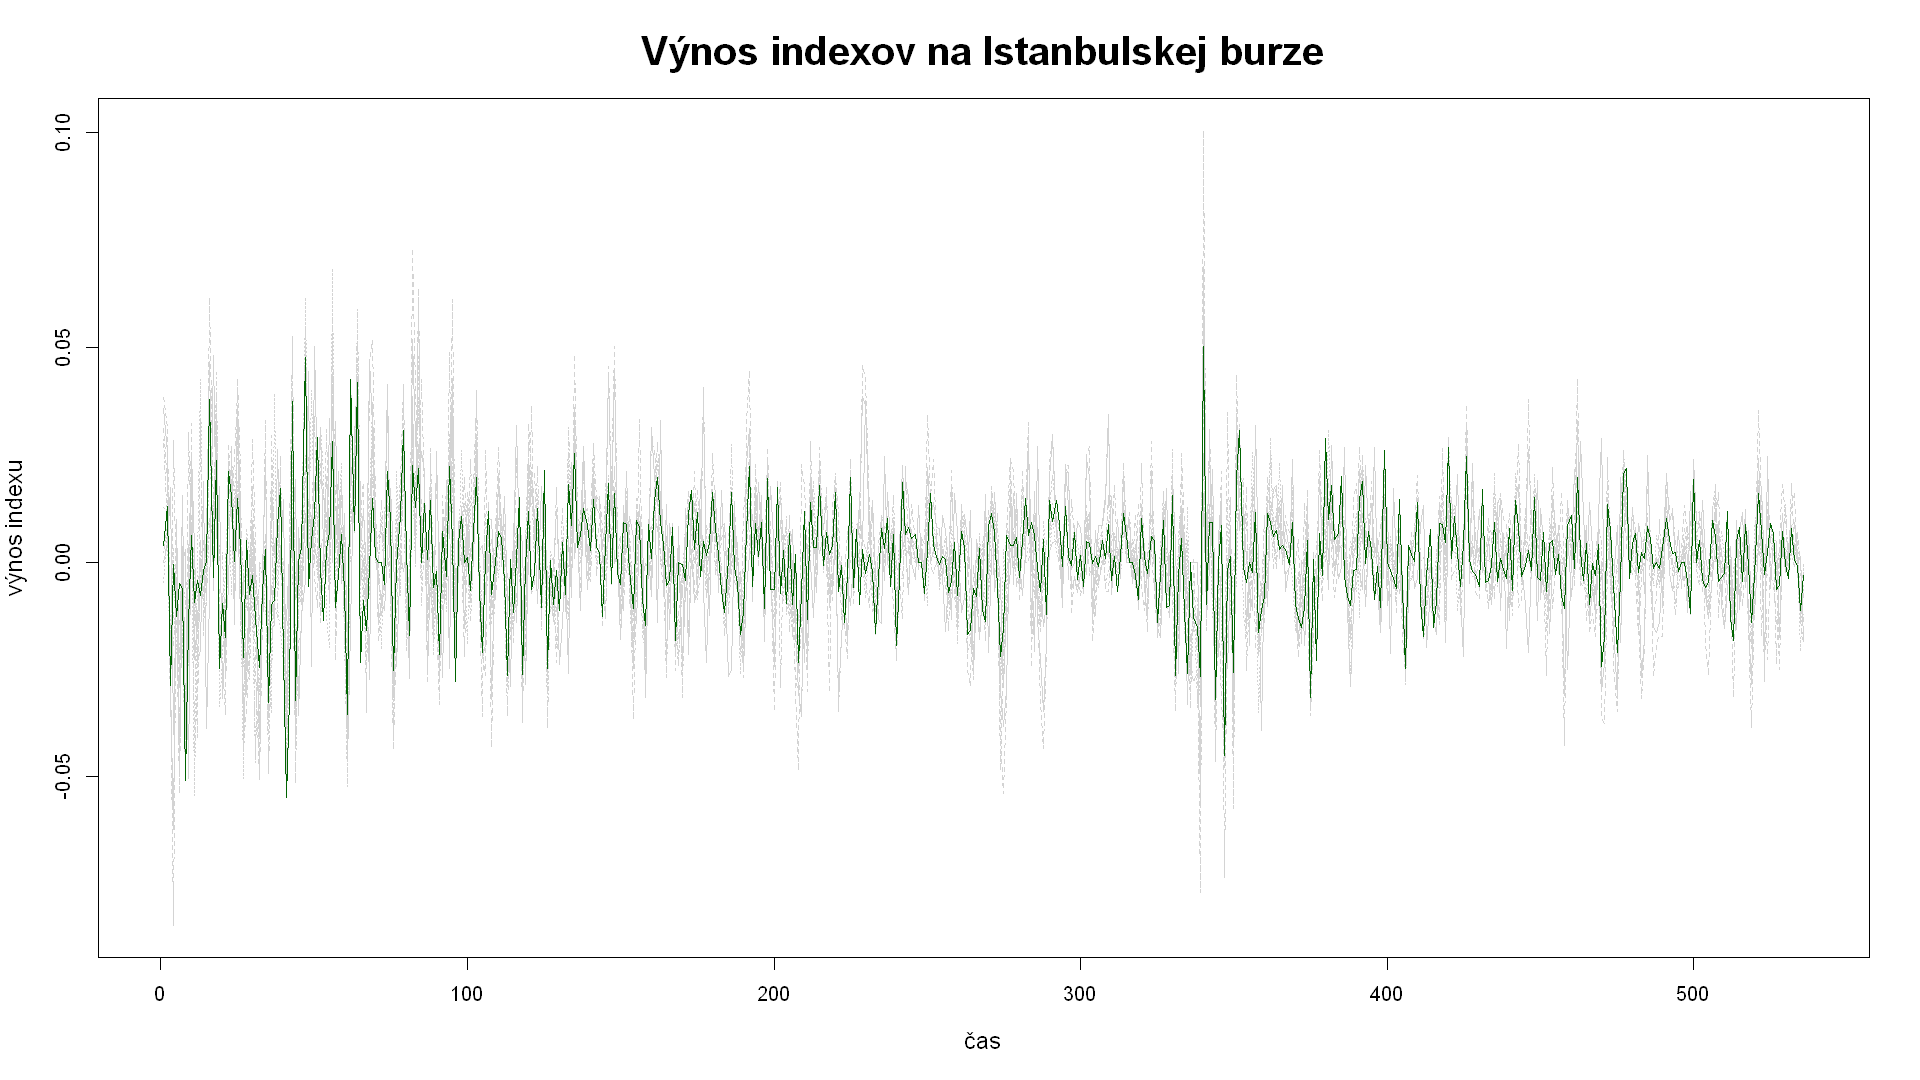

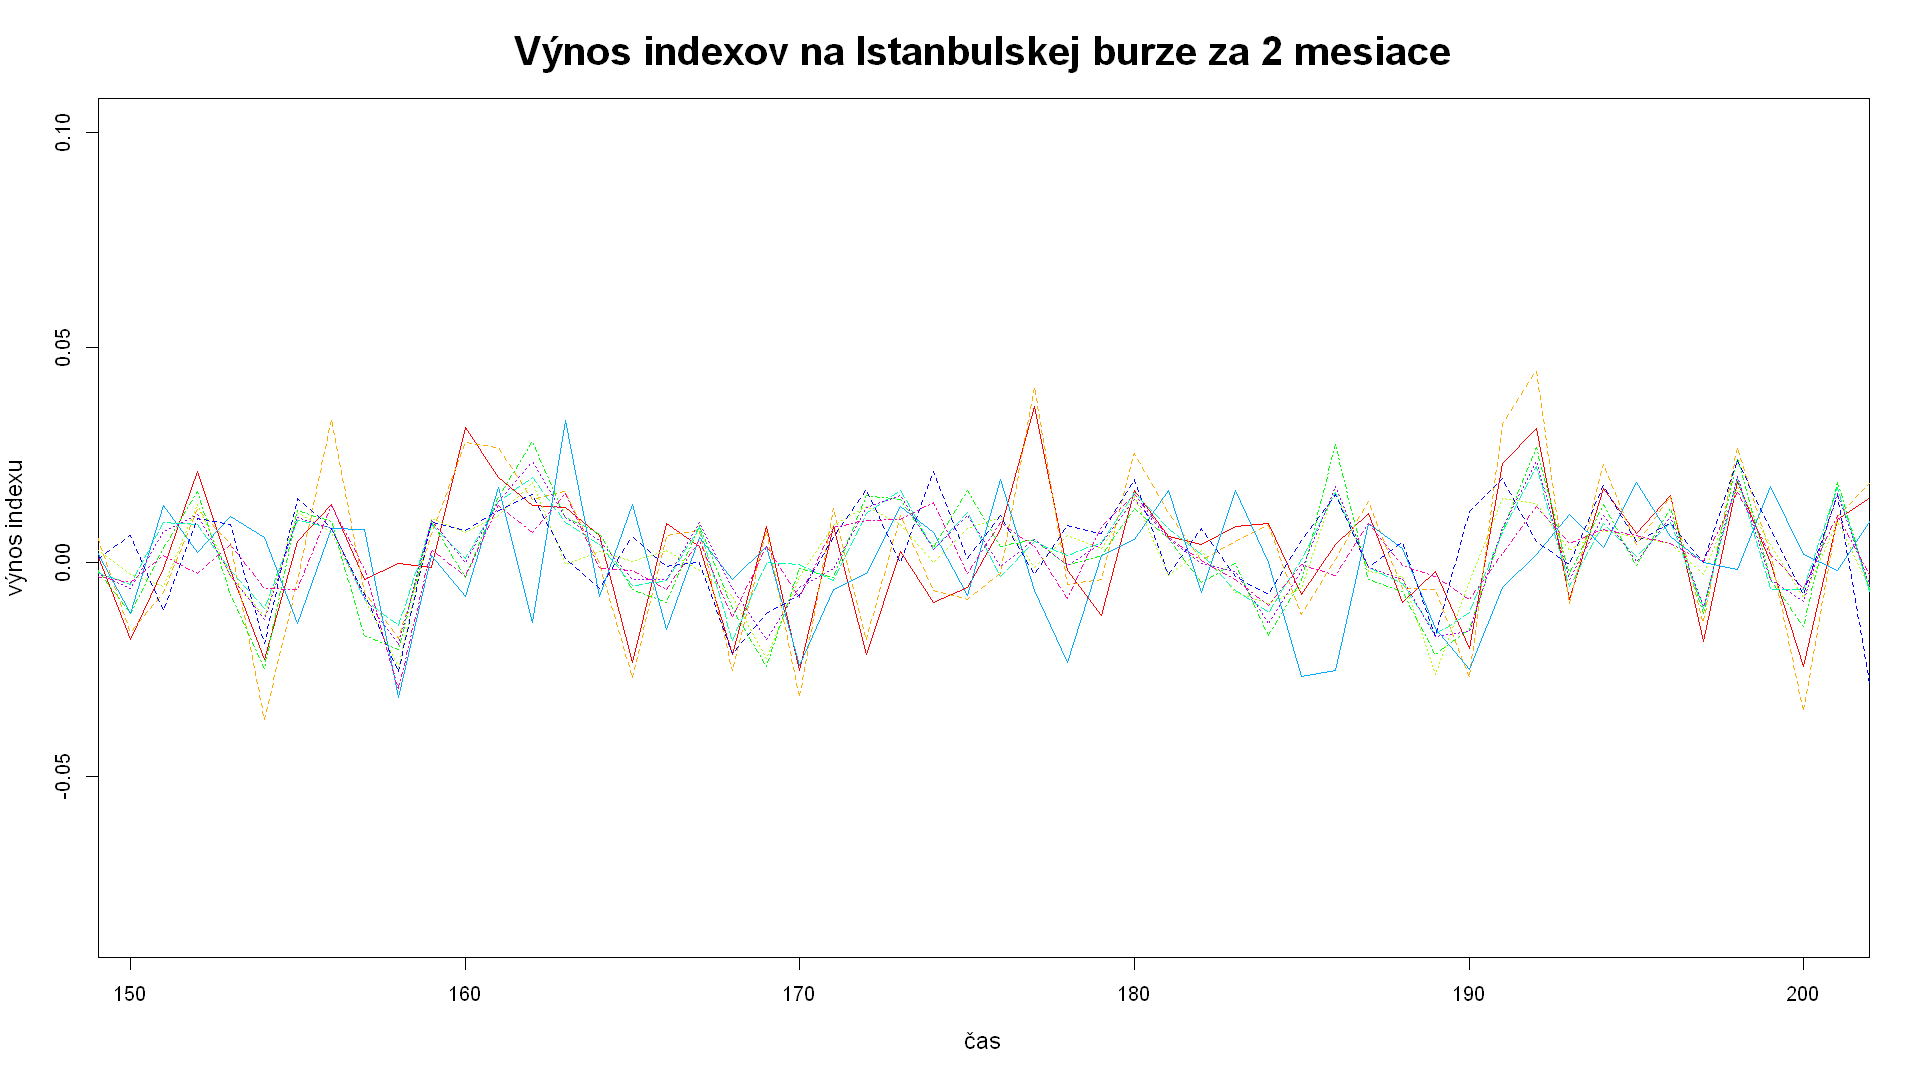

In [19]:
options(repr.plot.width=16, repr.plot.height=9)
matplot(cas, data[,-1], type="l", col="lightgray", main="Výnos indexov na Istanbulskej burze", cex.main=2, cex.lab=1.15, 
        ylab="výnos indexu", xlab="čas")
sel.crv <- sample(1:9, size = 1, replace = FALSE)
matlines(cas, data[,sel.crv], type='l', lty=1, lwd=1, col = "darkgreen")

matplot(cas, data[,-1], type="l", col=rainbow(9), main="Výnos indexov na Istanbulskej burze za 2 mesiace", 
        cex.main=2, cex.lab=1.15, xlim=c(151,200), ylab="výnos indexu", xlab="čas")

**<font size=4 color=darkblue> 3.2 Implementácia FPCA a interpretácia výsledkov </font>** <br>

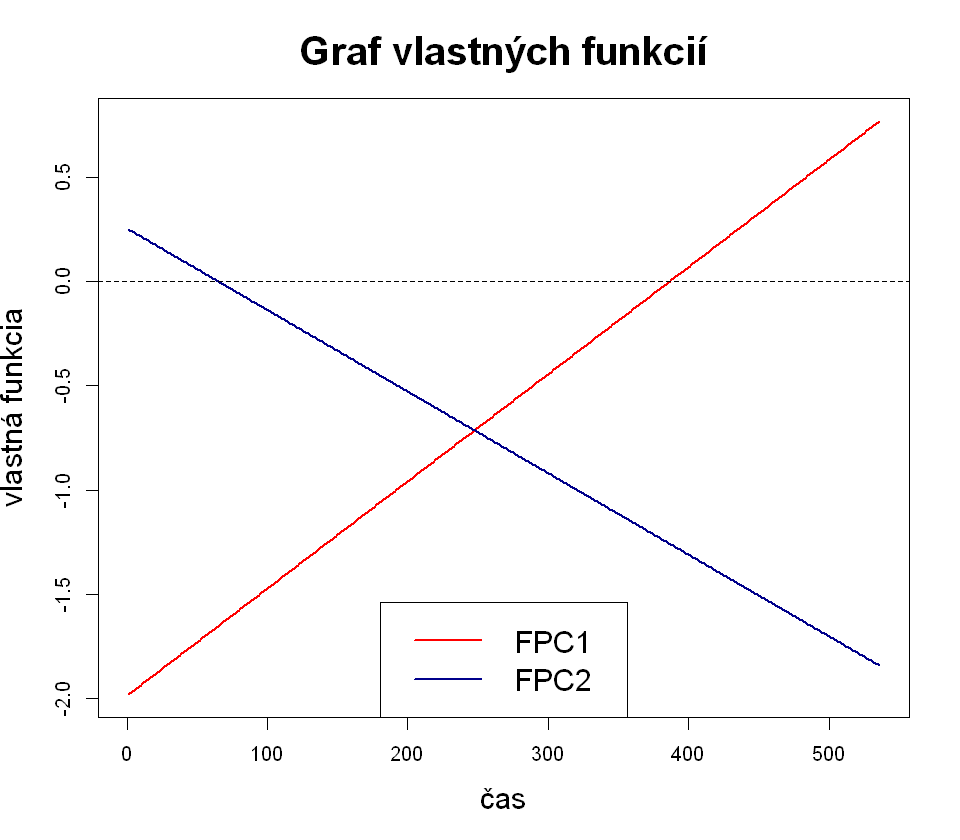

In [20]:
burza_fpca <- fpca.face(Y = t(data[,-1]), argvals = 1:536, pve = 0.95)

efn.face <- burza_fpca$efunctions*sqrt(536)
eval.face <- burza_fpca$evalues/536

options(repr.plot.width=8, repr.plot.height=7)

matplot(1:536, efn.face[,1:burza_fpca$npc], col=c("red", "darkblue"), 
        type='l', lty=1, lwd=2,
        ylab="vlastná funkcia", xlab="čas",
        main="Graf vlastných funkcií", cex.main=2, cex.lab=1.5)
abline(0,0, lty=2)
legend("bottom", lwd=2, lty=1, col=c("red", "darkblue"), 
      legend = paste0("FPC", 1:2),cex=1.5)

Vlastné funkcie sú síce lineárne, ale tažšie na interpretáciu. Môžme teraz len hádať, ako si ich vysvetliť, najviac nám môže pomôcť graf skóre komponentov. Predtým si ale ešte vykreslíme grafy účinkov komponentov na krivku priemeru. 

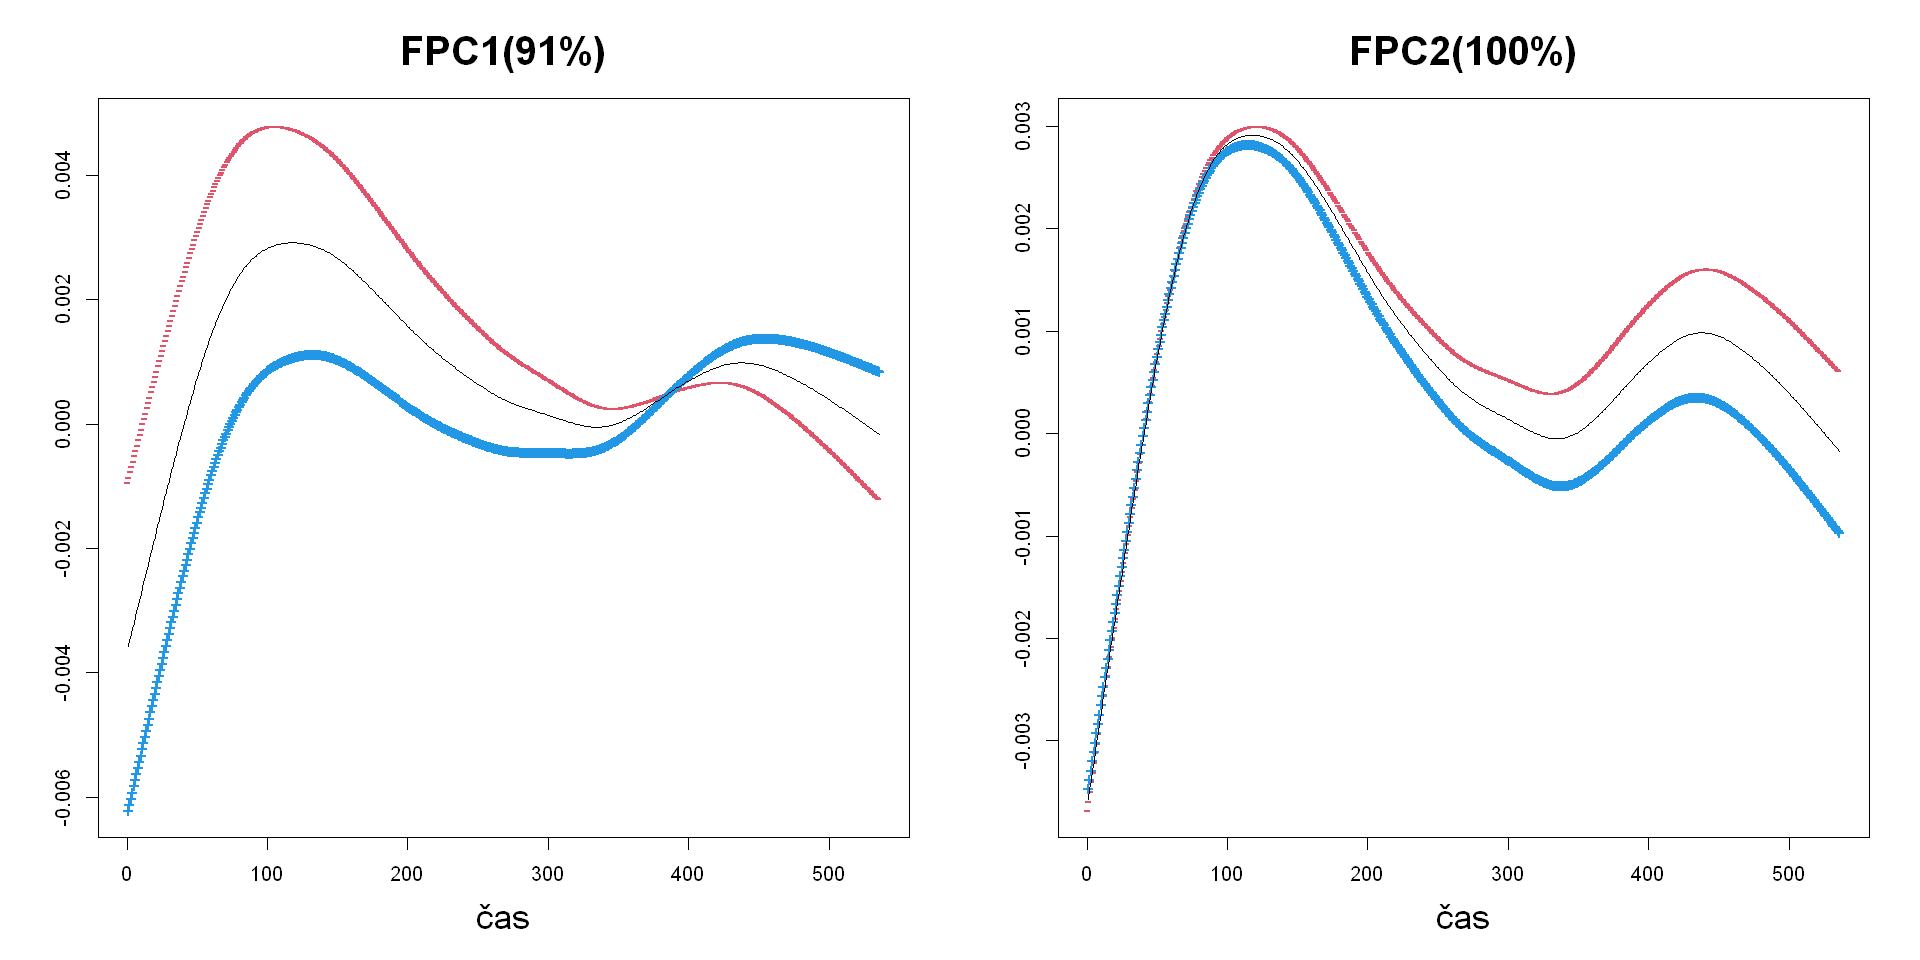

In [21]:
options(repr.plot.width=16, repr.plot.height=8)
par(mfrow=c(1,2))
for (i in 1:2){
 k.pc <- i
mu.hat <- burza_fpca$mu
effect <- efn.face[,k.pc] * 2* sqrt(eval.face[k.pc])
pve.face <- (cumsum(eval.face)/sum(eval.face))

matplot(cas, cbind(mu.hat - effect, mu.hat + effect),
        pch = c("-", "+"), ylab="", xlab="čas", col=c(2,4),
        main=paste0("FPC", k.pc,"(", round(pve.face[k.pc]*100) ,"%)"), cex.main=2, cex.lab=1.75)
lines(cas, mu.hat, lty=1, lwd=1) }

* Prvý komponent dáva do kontrastu indexy, ktoré sa líšia zhruba prvých 350 obchodovacích dní zo sledovaného obdobia, čo je zhruba 1 a pol kalendárneho roka a zároveň vysvetlí až **91% rozptylu** pôvodných dát.
* Druhý komponent dáva do konstrastu inexy, ktoré sa líšia zhruba v druhej polovici sledovaného obdobia a zároveň spolu s prvou kompoentou vysvetlia skoro **100% rozptylu** pôvodných dát. 

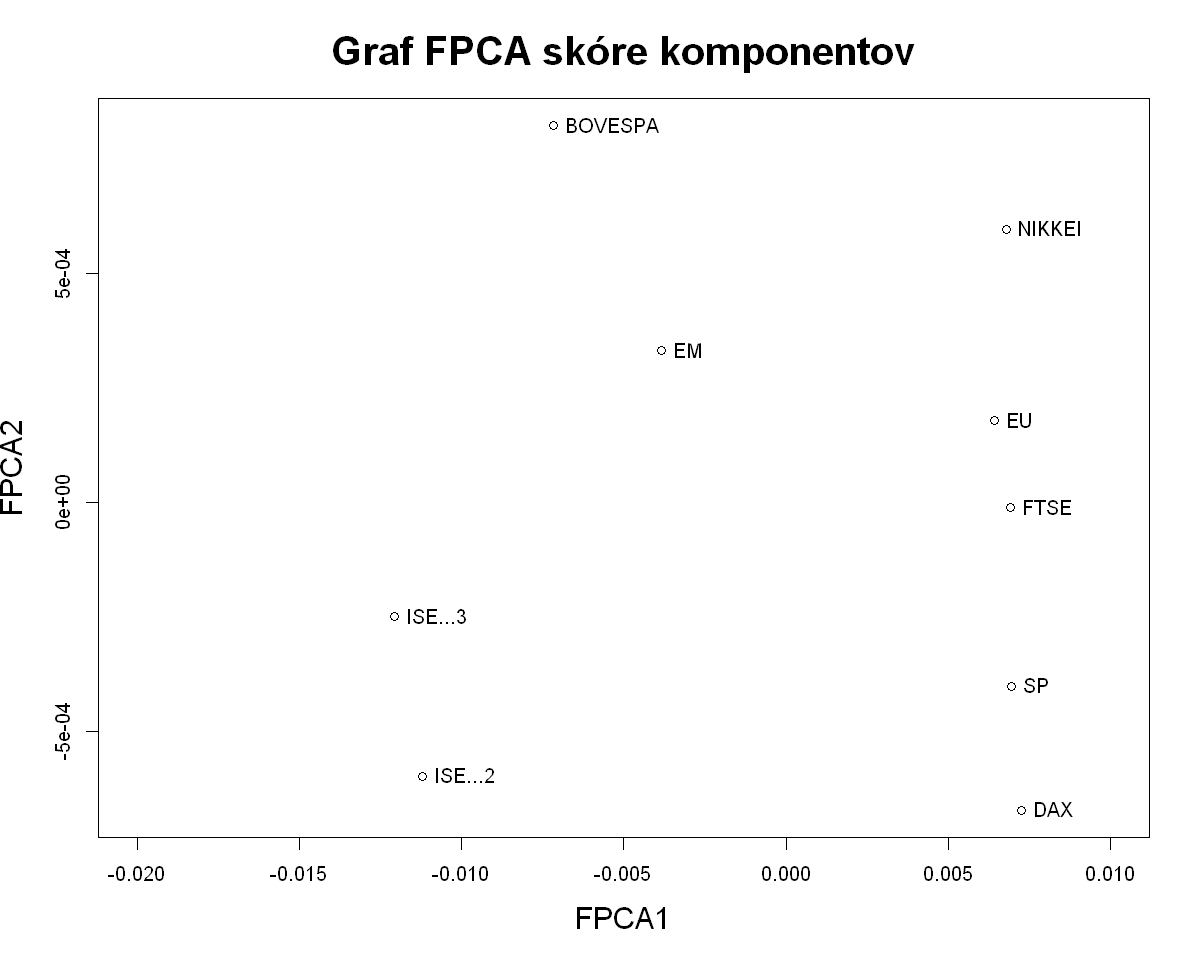

In [22]:
options(repr.plot.width=10, repr.plot.height=8)
plot(burza_fpca$scores, xlab="FPCA1", ylab="FPCA2", xlim=c(-0.02,0.01), main="Graf FPCA skóre komponentov",
     cex.main=2, cex.lab=1.5)
text(burza_fpca$scores[,1],burza_fpca$scores[,2],rownames(burza_fpca$scores),pos=4)

Graf skóre komponentov nám dáva nasledujúce vysvetlenie:
* vysoké skóre prvého komponentu majú indexy krajín rozvinutého sveta (Nemecko, Spojené kráľovstvo, Japonsko, Európa) a nízke skóre prvého komponentu majú indexy krajín rýchlo rozvíjajúceho sa sveta (ázijske krajiny, Turecko, Brazília).
* Druhý komponnt nám dáva do kontrastu indexy krajín s nízkym skóre druhého komponentu (Nemecko, USA a Turecko), voči krajinám s vysokým skóre pre druhý komponent (Brazília, Japonsko). Zdá sa, že tento komponent delí krajiny vzhľadom na ich zemepisnú dĺžku.

***
<a id=References></a>
# <font color=darkblue> 4. Zdroje </font>

* Goldsmith, J. et al., (2023). refund: Regression with Functional Data. 2023


* Nychka, D., Furrer, R., Paige, J., & Sain, S. (2021). “fields: Tools for spatial data.” R package version 14.1, 


* Ramsay, J., Hooker, G., & Graves, S. (2022). fda: Functional Data Analysis. 2022


* Ramsay, J. O., & Silverman, B. W. (2005). Functional data analysis (2nd ed). Springer.


* Staicu, A.-M., & Park, S. Y. (2016). Short Course on Applied Functional Data Analysis. [Online kurz.](https://www4.stat.ncsu.edu/~staicu/FDAtutorial/index.html)


* Wickham, H., Hester, J.,  & Bryan, J. (2022). readr: Read Rectangular Text Data. R
  package version 2.1.2.



* Wickham, H., &  Bryan, J. (2019). readxl: Read Excel Files. R package version 1.3.1.
 

